---
syncID: 6eb4422d262440408f7905d1dd3d1ae2
title: "Make Training Data for Species Modeling from NEON TOS Vegetation Structure Data"
description: "Create a training dataset for tree classification using TOS vegetation structure data."
dateCreated: 2025-07-30
authors: Bridget Hass
contributors: Claire Lunch
estimatedTime: 30 minutes
packagesLibraries: Python
topics: vegetation structure, classification
languageTool: Python
dataProduct: DP1.10098.001
code1: https://raw.githubusercontent.com/NEONScience/NEON-Data-Skills/main/tutorials/Python/AOP/Hyperspectral/classification/refl-h5-xarray/make_classification_training_data.ipynb
tutorialSeries: 
urlTitle: classification-training-data

---

<div id="ds-objectives" markdown="1">

This notebook demonstrates how to generate a training dataset consisting of tree species, family, and location from the NEON Terrestrial Observation System (TOS) Vegetation Structure data product <a href="https://data.neonscience.org/data-products/DP1.10098.001" target=_blank>DP1.10098.001</a>. We will use data from the <a href="https://www.neonscience.org/field-sites/serc" target=_blank>Smithsonian Environmental Research Center (SERC)</a> site in Maryland. In a subsequent tutorial titled <a href="https://www.neonscience.org/resources/learning-hub/tutorials/refl-classification-pyxarray" target=_blank>Tree Classification with NEON Airborne Imaging Spectrometer Data using Python xarray</a>, we will use this training dataset to train a random forest machine learning model that predicts tree families from the hyperspectral signatures obtained from the airborne remote sensing data. These two tutorials outline a relatively simple modeling example, and represent a starting point for conducting machine learning analyses using NEON data!

### Set Up Python Environment

To run this notebook, you will need the following Python packages, which can be installed using `!pip install` or `!conda install` from within the notebook. Note that to use the `neonutilities` package, you will need Python version 3.9 or higher.

- matplotlib
- neonutilities
- numpy
- pandas
- requests
- seaborn

### Create a NEON AOP Token
 - NEON API Token (optional, but strongly recommended), see [NEON API Tokens Tutorial](https://www.neonscience.org/resources/learning-hub/tutorials/neon-api-tokens-tutorial) for more details on how to create and set up your token in Python (and R). Once you create your token (on the [NEON User Accounts](https://www.neonscience.org/about/user-accounts)) page, this notebook will show you how to set it as an environment variable and use it for downloading AOP data.

### Learning Objectives
- Use the `neonutilities` `load_by_product` function to read in NEON vegetation structure data at a given site
- Use the NEON locations API to determine the geographic position of the vegetation records in UTM x, y coordinates
- Filter the datset to include only the latest data and columns of interest
- Filter the data geospatially to keep data that are within a single AOP 1 km x 1 km tile

**Disclaimer**: this notebook is intended to provide an example of how to create an initial training data set for pairing with remote sensing data, and to conduct some exploratory analysis of the vegetation structure data. This does not incorporate outlier detection and removal, or comprehensive pre-processing steps. As part of creating a machine learning model, it is important to assess the training data quality and look for outliers or other potential data quality issues which may impact model results. Refer to the <a href="https://www.neonscience.org/resources/learning-hub/tutorials/tree-heights-veg-structure-chm" target=_blank>Compare tree height measured from the ground to a Lidar-based Canopy Height Model</a> lesson (the first additional resource above) for more details on how you would address geographic mismatch between the AOP and TOS data.

### Additional Resources

- The lesson <a href="https://www.neonscience.org/resources/learning-hub/tutorials/tree-heights-veg-structure-chm" target=_blank>Compare tree height measured from the ground to a Lidar-based Canopy Height Model</a> is another example of linking ground to airborne data, and shows similar steps of pre-processing TOS woody vegetation data.

- The paper <a href="https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3002700" target=_blank>Individual canopy tree species maps for the National Ecological Observatory Network</a> outlines methods for large-scale classification using NEON data. The associated NEON Science Seminar <a href="https://www.neonscience.org/get-involved/events/science-seminar-harnessing-neon-enable-future-forest-remote-sensing" target=_blank>Harnessing NEON to enable the future of forest remote sensing</a> may be a useful resource. This talk provides a high-level overview of modeling approaches for tree crown delineation and tree classification using NEON airborne remote sensing data. You can also watch the video below.

<p align="center"><iframe src="https://www.youtube.com/embed/Weru3hJbwTs" title="Science Seminar: Harnessing NEON to enable the future of forest remote sensing" frameborder="0" allowfullscreen></iframe>

- Refer to the <a href="https://data.neonscience.org/api/v0/documents/NEON_vegStructure_userGuide_vE?inline=true" target=_blank>Vegetation Structure User Guide</a> for more details on this data product, and to better understand the data quality flags, the sampling.

</div>

## 1. Download and Explore Vegetation Structure Data (DP1.10098.001)

In this first section we’ll load the vegetation structure data, find the locations of the mapped trees, and join to the species and family observations.

Let's get started! First, import the required Python packages.

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import neonutilities as nu
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import time

Set up your NEON token. See the setup instructions at the beginning of the tutorial on how to set up a NEON user account and create a token, if you have not already done so.

In [2]:
# copy and paste your NEON token from your NEON user account page here
my_token=""

We can load the vegetation structure data using the `load_by_product` function in the `neonutilities` package (imported as `nu`). Inputs to the function can be shown by typing `help(load_by_product)`.
  
Refer to the <a href="https://www.neonscience.org/sites/default/files/cheat-sheet-neonUtilities.pdf" target=_blank>R neonUtilities cheat sheet</a> or the <a href="https://neon-utilities-python.readthedocs.io/en/latest/" target=_blank>Python neonutilities documentation</a> for more details and the complete list of possible function inputs. The cheat sheet is focused on the R package, but nearly all the inputs are the same in Python neonutilities.

Note that in this example, we will pull in all the woody vegetation data (collected over all years), but if you are trying to model data collected  in a single year, you can select just that year by specifying the `startdate` and `enddate`, or later filtering out the vegetation data by the `eventID` We have set `check_size=False` since the data are not very large, but to check the size of what the data you are downloading first, you could omit this input, or set it to `True`.

In [3]:
veg_dict = nu.load_by_product(dpid="DP1.10098.001", 
                              site="SERC", 
                              package="basic", 
                              release="RELEASE-2025",
                              token=my_token,
                              check_size=False)

Finding available files
100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:14<00:00,  1.55it/s]
C:\Users\bhass\Anaconda3\envs\aop310\lib\site-packages\neonutilities\unzip_and_stack.py:141: UserWarning: Filepaths on Windows are limited to 260 characters. Attempting to extract a filepath that is > 260 characters long. Move your working or savepath directory closer to the root directory or enable long path support in Windows.
  warnings.warn(
Stacking data files
100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.06it/s]


Get a list of the points

In [4]:
veg_map_all = veg_dict["vst_mappingandtagging"]
veg_map = veg_map_all.loc[veg_map_all["pointID"] != ""]
veg_map = veg_map.reindex()
veg_map["points"] = veg_map["namedLocation"] + "." + veg_map["pointID"]
veg_points = list(set(list(veg_map["points"])))

Look at the unique `eventID`s. . All sampling at a site that occurs within a given bout is identified by a unique eventID, which represents the date of the bout.

In [5]:
veg_map_all.eventID.unique()

array(['vst_SERC_2015', 'vst_SERC_2016', 'vst_SERC_2017', 'vst_SERC_2018',
       'vst_SERC_2019', 'vst_SERC_2020', 'vst_SERC_2021', 'vst_SERC_2022',
       'vst_SERC_2023'], dtype=object)

Get the number of records for each `eventID`:

In [6]:
# Group by 'eventID' and get the count
eventID_counts = veg_map_all[['individualID','eventID']].groupby(['eventID']).count()
print("\nCounts of each eventID:\n", eventID_counts)


Counts of each eventID:
                individualID
eventID                    
vst_SERC_2015          1890
vst_SERC_2016          1330
vst_SERC_2017            96
vst_SERC_2018           127
vst_SERC_2019           254
vst_SERC_2020            22
vst_SERC_2021            54
vst_SERC_2022           494
vst_SERC_2023            40


It looks like most of the trees were mapped in 2015 and 2016, which was when the SERC plots were first established. You could look at data only from one year, and compare to AOP data from the same year, or if you are not too worried about matching measurements to remote sensing data collected in the same year, you could use all years. We'll do the latter in this example.

## 2. Determine the geographic location of the surveyed vegetation

Loop through all of the points in `veg_points` to determine the easting and northing from the <a href="https://data.neonscience.org/data-api/endpoints/locations/" target=_blank>NEON Locations API</a>. In some rare cases, mostly in older data, there may be points that are not found in the location database. The `if/else` block below handles the case where location data are missing.

In [7]:
easting = []
northing = []
coord_uncertainty = []
elev_uncertainty = []
drop_points = []
for i in veg_points:
    time.sleep(1) # helps avoid hitting the API rate limit
    vres = requests.get("https://data.neonscience.org/api/v0/locations/"+i)
    vres_json = vres.json()
    # discard points that aren’t found in the location database
    if vres_json["data"] is not None:
        easting.append(vres_json["data"]["locationUtmEasting"])
        northing.append(vres_json["data"]["locationUtmNorthing"])
        props = pd.DataFrame.from_dict(vres_json["data"]["locationProperties"])
        cu = props.loc[props["locationPropertyName"] == "Value for Coordinate uncertainty"]["locationPropertyValue"]
        coord_uncertainty.append(cu[cu.index[0]])
        eu = props.loc[props["locationPropertyName"] == "Value for Elevation uncertainty"]["locationPropertyValue"]
        elev_uncertainty.append(eu[eu.index[0]])
    else:
        drop_points.append(i)

veg_points_clean = [v for v in veg_points if v not in drop_points]

Now we can create a dataframe containing the vegetation data.

In [8]:
pt_dict = dict(points=veg_points_clean, 
               easting=easting,
               northing=northing,
               coordinateUncertainty=coord_uncertainty,
               elevationUncertainty=elev_uncertainty)

pt_df = pd.DataFrame.from_dict(pt_dict)
pt_df.set_index("points", inplace=True)

veg_map = veg_map.join(pt_df, 
                     on="points", 
                     how="inner")

Next, use the `stemDistance` and `stemAzimuth` data to calculate the precise locations of individuals, relative to the reference locations.

- $Easting = easting.pointID + stemDistance*sin(\theta)$
- $Northing = northing.pointID + stemDistance*cos(\theta)$
- $\theta = stemAzimuth*\pi/180$

Also adjust the coordinate and elevation uncertainties.

In [9]:
veg_map["adjEasting"] = (veg_map["easting"]
                        + veg_map["stemDistance"]
                        * np.sin(veg_map["stemAzimuth"]
                                   * np.pi / 180))

veg_map["adjNorthing"] = (veg_map["northing"]
                        + veg_map["stemDistance"]
                        * np.cos(veg_map["stemAzimuth"]
                                   * np.pi / 180))

veg_map["adjCoordinateUncertainty"] = veg_map["coordinateUncertainty"] + 0.6

veg_map["adjElevationUncertainty"] = veg_map["elevationUncertainty"] + 1

Look at the columns to see all the information contained in this dataset.

In [10]:
# look at a subset of the columns that may be relevant
veg_map[['date','individualID','scientificName','taxonID','family','plotID','pointID','adjEasting','adjNorthing']].head(5)

,date,individualID,scientificName,taxonID,family,plotID,pointID,adjEasting,adjNorthing
1,2015-03-23,NEON.PLA.D02.SERC.08038,Carya glabra (Mill.) Sweet,CAGL8,Juglandaceae,SERC_045,43,364809.083993,4.304727e+06
2,2015-03-23,NEON.PLA.D02.SERC.08036,Liriodendron tulipifera L.,LITU,Magnoliaceae,SERC_045,21,364779.130881,4.304717e+06
6,2015-03-23,NEON.PLA.D02.SERC.05664,Quercus montana Willd.,QUMO4,Fagaceae,SERC_062,59,364857.704931,4.304826e+06
9,2015-03-23,NEON.PLA.D02.SERC.08009,Acer rubrum L.,ACRU,Aceraceae,SERC_045,23,364795.325837,4.304706e+06
10,2015-03-23,NEON.PLA.D02.SERC.08016,Acer rubrum L.,ACRU,Aceraceae,SERC_045,23,364790.181050,4.304714e+06


In [11]:
len(veg_map)

1211

## 3. Filter to trees within an AOP tile extent

Now create a new dataframe containing only the veg data that are within a single AOP tile (which are 1 km x 1 km in size). For this, you will need to know the bounds (minimum and maximum UTM easting and northing) of the area you are sampling. For this exercise, we will choose the AOP data with SW (lower left) UTM coordinates of 364000, 4305000. This tile encompasses the NEON tower at the SERC site.

In [12]:
veg_tower_tile = veg_map[(veg_map['adjEasting'].between(364000, 365000)) & (veg_map['adjNorthing'].between(4305000, 4306000))]

How many records do we have within this tile?

In [13]:
len(veg_tower_tile)

211

There are 211 unique vegetation records in this area. We can also look at the unique `taxonID`s that are represented.

In [14]:
# look at the unique Taxon IDs
veg_tower_tile.taxonID.unique()

array(['LIST2', 'ACRU', 'FAGR', 'ULMUS', 'LITU', 'CACA18', 'NYSY', 'QUFA',
       'QURU', 'QUAL', 'CAGL8', 'CATO6', 'QUVE', 'COFL2', 'QUERC',
       'QUMA3', 'PRAV', 'PINUS'], dtype=object)

Let's keep only a subset of the columns that we are interested in, and look at the dataframe:

In [15]:
veg_tower_tile_short = veg_tower_tile[['date','individualID','scientificName','taxonID','family','adjEasting','adjNorthing']]
veg_tower_tile_short.reset_index(drop=True, inplace=True)
veg_tower_tile_short

,date,individualID,scientificName,taxonID,family,adjEasting,adjNorthing
0,2015-03-25,NEON.PLA.D02.SERC.05537,Liquidambar styraciflua L.,LIST2,Hamamelidaceae,364578.230724,4.305896e+06
1,2015-03-25,NEON.PLA.D02.SERC.05546,Acer rubrum L.,ACRU,Aceraceae,364590.549216,4.305899e+06
2,2015-03-25,NEON.PLA.D02.SERC.05548,Fagus grandifolia Ehrh.,FAGR,Fagaceae,364586.368495,4.305883e+06
3,2015-03-25,NEON.PLA.D02.SERC.05549,Acer rubrum L.,ACRU,Aceraceae,364578.883395,4.305888e+06
4,2015-03-25,NEON.PLA.D02.SERC.05545,Acer rubrum L.,ACRU,Aceraceae,364590.276108,4.305897e+06
...,...,...,...,...,...,...,...
206,2023-01-10,NEON.PLA.D02.SERC.09712,Carya tomentosa (Lam.) Nutt.,CATO6,Juglandaceae,364708.570635,4.305389e+06
207,2023-01-11,NEON.PLA.D02.SERC.09708,Pinus sp.,PINUS,Pinaceae,364701.345113,4.305407e+06
208,2023-01-16,NEON.PLA.D02.SERC.09358,Pinus sp.,PINUS,Pinaceae,364438.131683,4.305409e+06
209,2023-01-16,NEON.PLA.D02.SERC.14563,Quercus alba L.,QUAL,Fagaceae,364470.101669,4.305412e+06


To get a better sense of the data, we can also look at the # of each species, to see if some species have more representation than others.

In [16]:
# display the taxonID counts, sorted descending
veg_tower_tile_taxon_counts = veg_tower_tile[['individualID','taxonID']].groupby(['taxonID']).count()
veg_tower_tile_taxon_counts.sort_values(by='individualID',ascending=False)

,individualID
taxonID,
FAGR,48
LITU,35
LIST2,29
ACRU,16
CAGL8,12
QUAL,11
CATO6,11
CACA18,11
NYSY,10


In [17]:
# display the family counts, sorted descending
veg_tower_tile_family_counts = veg_tower_tile[['individualID','family']].groupby(['family']).count()
veg_tower_tile_family_counts.sort_values(by='individualID',ascending=False)

,individualID
family,
Fagaceae,76
Magnoliaceae,35
Hamamelidaceae,29
Juglandaceae,23
Aceraceae,16
Cornaceae,13
Betulaceae,11
Ulmaceae,5
Pinaceae,2


It looks like there are a number of different species (and families) mapped in this tower plot. You can use the https://plants.usda.gov website to look up the species information. The top 5 most abundant mapped species are linked below.

- [FAGR](https://plants.usda.gov/plant-profile/FAGR): American Beech (Fagus grandifolia Ehrh.)
- [LITU](https://plants.usda.gov/plant-profile/LITU): Tuliptree (Liriodendron tulipifera L.)
- [LIST2](https://plants.usda.gov/plant-profile/LIST2): Sweetgum (Liquidambar styraciflua L.)
- [ACRU](https://plants.usda.gov/plant-profile/ACRU): Red Maple (Acer rubrum L.)
- [CAGL8](https://plants.usda.gov/plant-profile/CAGL8): Sweet pignut hickory (Carya glabra (Mill.))

When carrying out classification, the species that only have small representation (1-5 samples) may not be modeled accurately due to a lack of sufficient training data. The challenge of mapping rarer species due to insufficient training data is well known. In the next tutorial, we will remove these poorly represented samples before generating a model. 

## 4. Write training dataframe to csv file

Nonetheless, we have a fairly decent training dataset to work with. We can save the dataframe to a csv file called `serc_training_data.csv` as follows:

In [18]:
veg_tower_tile_short.to_csv(r'./data/serc_training_data.csv',index=False)

## 5. Plot tree families in map view

Finally, we can make a quick plot using `seaborn` (imported as `sns`) to show the spatial distrubtion of the trees surveyed in this area, along with their species (`scientificName`). Most of this code helps improve the formatting and appearance of the figure; the first `sns.scatterplot` chunk is all you really need to do to plot the essentials.

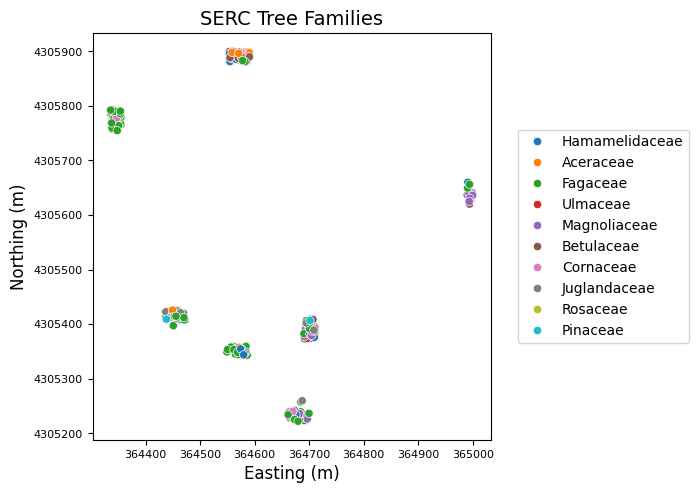

In [19]:
ax = sns.scatterplot(
    data=veg_tower_tile_short,
    x='adjEasting',
    y='adjNorthing',
    hue='family',
)

# Make the x and y dimensions are equal
ax.set_aspect('equal', adjustable='box')

# Remove scientific notation on the x and y axes labels
ax.xaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:.0f}'))
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, _: f'{y:.0f}'))

# Place the legend outside the plot at the center right
plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

# Adjust layout to prevent legend overlap
plt.tight_layout()

# Add title and axis labels
ax.set_title("SERC Tree Families", fontsize=14)
ax.set_xlabel("Easting (m)", fontsize=12)
ax.set_ylabel("Northing (m)", fontsize=12)
plt.yticks(fontsize=8)  
plt.xticks(fontsize=8)  

plt.show()

Great! We can see all the trees that were surveyed in this AOP tile. The trees are sampled in discrete plots. For more information about the TOS sampling design, please refer to the <a href="https://data.neonscience.org/data-products/DP1.10098.001" target=_blank>Vegetation structure</a> data product page.

## Recap

In this lesson, we have created a training data set containing information about the tree family and species as well as their geographic locations in UTM x, y coordinates. We can now pair this training data set with the remote sensing data and create a model to predict the tree's family based off airborne spectral data. The next tutorial, <a href="https://www.neonscience.org/resources/learning-hub/tutorials/refl-classification-pyxarray" target=_blank>Tree Classification with NEON Airborne Imaging Spectrometer Data using Python xarray</a>, will show how to do this!

**Note:** you may wish to create a training dataframe that contains additional information about the trees. For example, you can also include parameters like the growth form (e.g. whether the vegetation is a shrub, single-bole or multi-bole tree, etc.), the plant status (whether the tree is healthy or standing dead), and measurements such as the stem diameter and tree height. To do this, you would need to join the `vst_mappingandtagging` table with the `vst_apparentindividual` tables. Refer to the <a href="https://data.neonscience.org/api/v0/documents/quick-start-guides/NEON.QSG.DP1.00001.001v2?inline=TRUE" target=_blank>Quick Start Guide for Vegetation Structure</a> for more information about the data tables and the joining instructions. You can also refer to the lesson <a href="https://www.neonscience.org/resources/learning-hub/tutorials/tree-heights-veg-structure-chm" target=_blank>Compare tree height measured from the ground to a Lidar-based Canopy Height Model</a> which provides an example of how to do this and compare the TOS measured data with the AOP Lidar-derived Canopy Height Model (Ecosystem Structure) data product.